# Cell 1: 노트북 개요

## 05_bc_training.ipynb - 행동 클로닝 학습

이 노트북에서는 CARLA에서 수집한 Expert 데이터로 행동 클로닝(Behavior Cloning)을 수행합니다.

### 목표
1. CARLA 수집 데이터 로드
2. 사전학습된 Vision Encoder 활용
3. Policy Head 학습
4. 모델 평가

### 참고 논문
- **ALVINN** (Pomerleau, 1988): 최초의 End-to-end 자율주행
- **End-to-End Learning** (Bojarski et al., 2016): NVIDIA PilotNet
- **DAgger** (Ross et al., 2011): Distribution shift 문제 해결

In [1]:
# Cell 1: 라이브러리 및 설정

import sys
import os
import json
import glob
import logging
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as T
import torchvision.models as models

# 프로젝트 루트
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce GTX 1080 Ti


In [2]:
# Cell 2: 설정 로드

import yaml

# 설정 파일 로드
with open(PROJECT_ROOT / 'config' / 'training_config.yaml', 'r', encoding='utf-8') as f:
    training_config = yaml.safe_load(f)

with open(PROJECT_ROOT / 'config' / 'model_config.yaml', 'r', encoding='utf-8') as f:
    model_config = yaml.safe_load(f)

# BC 학습 설정
BC_CONFIG = training_config['bc_training']
print("행동 클로닝 학습 설정:")
for key, value in BC_CONFIG.items():
    print(f"  {key}: {value}")

행동 클로닝 학습 설정:
  batch_size: 32
  learning_rate: 0.0001
  weight_decay: 0.0001
  epochs: 50
  patience: 10
  encoder_freeze: True
  unfreeze_epoch: 20
  loss_weights: {'steer': 1.0, 'throttle': 0.5, 'brake': 0.5}


In [3]:
# Cell 3: CARLA 수집 데이터 로드

CARLA_DATA_DIR = PROJECT_ROOT / 'dataset' / 'carla_collected'

# 에피소드 디렉토리 찾기
episode_dirs = sorted(glob.glob(str(CARLA_DATA_DIR / 'episode_*')))

if episode_dirs:
    print(f"CARLA 수집 에피소드: {len(episode_dirs)}개")
    
    # 전체 데이터 로드
    all_frames = []
    for ep_dir in tqdm(episode_dirs, desc="데이터 로드"):
        parquet_path = Path(ep_dir) / 'frames.parquet'
        if parquet_path.exists():
            df = pd.read_parquet(parquet_path)
            df['episode_dir'] = ep_dir
            all_frames.append(df)
    
    if all_frames:
        data_df = pd.concat(all_frames, ignore_index=True)
        print(f"\n총 프레임: {len(data_df):,}")
        print(f"컬럼: {list(data_df.columns)}")
    else:
        print("⚠️ 로드된 데이터가 없습니다.")
        data_df = pd.DataFrame()
else:
    print("⚠️ CARLA 수집 데이터가 없습니다.")
    print("02_data_collection.ipynb를 먼저 실행해주세요.")
    data_df = pd.DataFrame()

CARLA 수집 에피소드: 14개


데이터 로드:   0%|          | 0/14 [00:00<?, ?it/s]


총 프레임: 14,000
컬럼: ['frame_id', 'world_frame', 'collision', 'lane_invasion', 'ego_speed', 'ego_location', 'ego_rotation', 'traffic_light', 'speed_limit', 'steer', 'throttle', 'brake', 'image_path', 'episode_dir']


충돌 제외 후: 14,000 프레임

액션 통계:
  Steer: mean=-0.0114, std=0.0462
  Throttle: mean=0.2593, std=0.2563
  Brake: mean=0.3763, std=0.4804


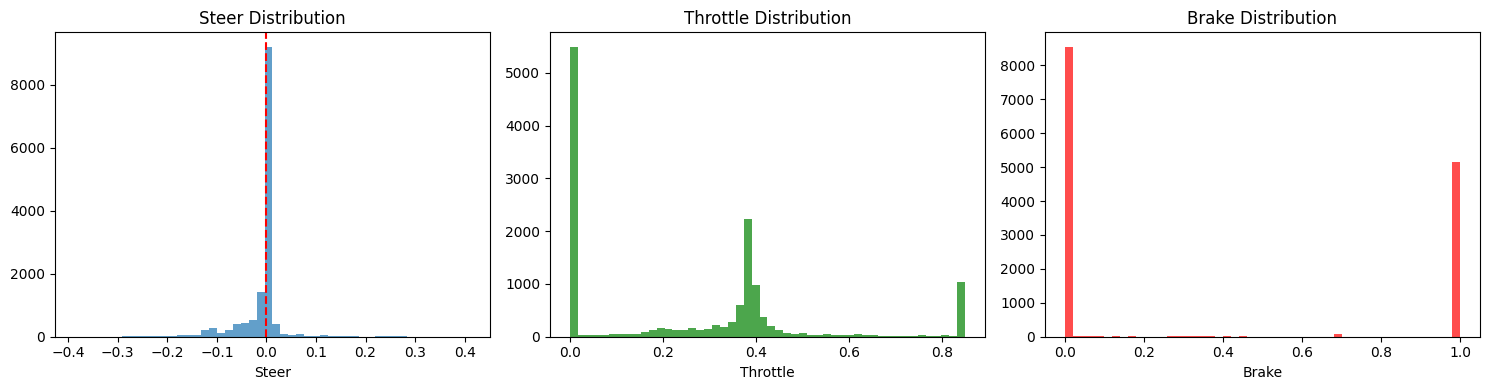

In [4]:
# Cell 4: 데이터 전처리 및 분석

if len(data_df) > 0:
    # 충돌/차선침범 데이터 제외 (선택적)
    clean_df = data_df[~data_df['collision']].copy()
    print(f"충돌 제외 후: {len(clean_df):,} 프레임")
    
    # 액션 통계
    print(f"\n액션 통계:")
    print(f"  Steer: mean={clean_df['steer'].mean():.4f}, std={clean_df['steer'].std():.4f}")
    print(f"  Throttle: mean={clean_df['throttle'].mean():.4f}, std={clean_df['throttle'].std():.4f}")
    print(f"  Brake: mean={clean_df['brake'].mean():.4f}, std={clean_df['brake'].std():.4f}")
    
    # 액션 분포 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(clean_df['steer'], bins=50, alpha=0.7)
    axes[0].set_xlabel('Steer')
    axes[0].set_title('Steer Distribution')
    axes[0].axvline(0, color='red', linestyle='--')
    
    axes[1].hist(clean_df['throttle'], bins=50, alpha=0.7, color='green')
    axes[1].set_xlabel('Throttle')
    axes[1].set_title('Throttle Distribution')
    
    axes[2].hist(clean_df['brake'], bins=50, alpha=0.7, color='red')
    axes[2].set_xlabel('Brake')
    axes[2].set_title('Brake Distribution')
    
    plt.tight_layout()
    plt.show()
else:
    clean_df = pd.DataFrame()

In [5]:
# Cell 5: CARLA 데이터셋 클래스

class CARLABCDataset(Dataset):
    """
    CARLA 행동 클로닝 데이터셋
    
    입력: RGB 이미지
    출력: [steer, throttle, brake]
    """
    
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform or T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        print(f"데이터셋 크기: {len(self.df):,}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 이미지 로드
        image_path = row['image_path']
        image = cv2.imread(image_path)
        
        if image is None:
            # 로드 실패 시 다른 인덱스 반환
            return self.__getitem__((idx + 1) % len(self))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 변환 적용
        image = self.transform(image)
        
        # 액션 (정답)
        action = torch.tensor([
            row['steer'],
            row['throttle'],
            row['brake']
        ], dtype=torch.float32)
        
        return image, action

print("✅ CARLABCDataset 정의 완료")

✅ CARLABCDataset 정의 완료


In [6]:
# Cell 6: 전체 모델 정의 (Encoder + Policy Head)

class DrivingPolicyModel(nn.Module):
    """
    자율주행 정책 모델
    
    구조:
    1. Vision Encoder (사전학습된 ResNet-50)
    2. Policy Head (MLP)
    
    출력: [steer, throttle, brake]
    """
    
    def __init__(self, encoder_type='resnet50', pretrained_ssl_path=None, freeze_encoder=True):
        super().__init__()
        
        # Vision Encoder
        if encoder_type == 'resnet50':
            self.encoder = models.resnet50(pretrained=True)
            self.feature_dim = self.encoder.fc.in_features  # 2048
            self.encoder.fc = nn.Identity()
        elif encoder_type == 'resnet34':
            self.encoder = models.resnet34(pretrained=True)
            self.feature_dim = self.encoder.fc.in_features  # 512
            self.encoder.fc = nn.Identity()
        else:
            raise ValueError(f"Unknown encoder: {encoder_type}")
        
        # SSL 사전학습 가중치 로드
        if pretrained_ssl_path and Path(pretrained_ssl_path).exists():
            checkpoint = torch.load(pretrained_ssl_path, map_location='cpu')
            if 'encoder_state_dict' in checkpoint:
                self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
                print(f"✅ SSL 사전학습 가중치 로드: {pretrained_ssl_path}")
            else:
                print("⚠️ encoder_state_dict를 찾을 수 없습니다.")
        
        # Encoder 동결
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
            print("🔒 Encoder 동결됨")
        
        # Policy Head
        hidden_dims = model_config['policy_head']['hidden_dims']  # [512, 256]
        dropout = model_config['policy_head']['dropout']  # 0.3
        
        self.policy_head = nn.Sequential(
            nn.Linear(self.feature_dim, hidden_dims[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], 3)  # [steer, throttle, brake]
        )
        
        # 출력 활성화
        self.steer_activation = nn.Tanh()  # [-1, 1]
        self.throttle_brake_activation = nn.Sigmoid()  # [0, 1]
        
        print(f"모델 생성: encoder={encoder_type}, feature_dim={self.feature_dim}")
    
    def forward(self, x):
        # Encoder
        features = self.encoder(x)
        
        # Policy Head
        raw_output = self.policy_head(features)
        
        # 활성화 함수 적용
        steer = self.steer_activation(raw_output[:, 0:1])
        throttle = self.throttle_brake_activation(raw_output[:, 1:2])
        brake = self.throttle_brake_activation(raw_output[:, 2:3])
        
        action = torch.cat([steer, throttle, brake], dim=1)
        
        return action
    
    def unfreeze_encoder(self):
        """Encoder 동결 해제 (fine-tuning용)"""
        for param in self.encoder.parameters():
            param.requires_grad = True
        print("🔓 Encoder 동결 해제됨")

print("✅ DrivingPolicyModel 정의 완료")

✅ DrivingPolicyModel 정의 완료


In [7]:
# Cell 7: 손실 함수 정의

class BCLoss(nn.Module):
    """
    행동 클로닝 손실 함수
    
    L = w_steer * MSE(steer) + w_throttle * MSE(throttle) + w_brake * MSE(brake)
    """
    
    def __init__(self, steer_weight=1.0, throttle_weight=0.5, brake_weight=0.5):
        super().__init__()
        self.steer_weight = steer_weight
        self.throttle_weight = throttle_weight
        self.brake_weight = brake_weight
        self.mse = nn.MSELoss()
    
    def forward(self, predicted, target):
        """
        Args:
            predicted: [batch, 3] - [steer, throttle, brake]
            target: [batch, 3] - [steer, throttle, brake]
        """
        steer_loss = self.mse(predicted[:, 0], target[:, 0])
        throttle_loss = self.mse(predicted[:, 1], target[:, 1])
        brake_loss = self.mse(predicted[:, 2], target[:, 2])
        
        total_loss = (
            self.steer_weight * steer_loss +
            self.throttle_weight * throttle_loss +
            self.brake_weight * brake_loss
        )
        
        return total_loss, {
            'steer': steer_loss.item(),
            'throttle': throttle_loss.item(),
            'brake': brake_loss.item()
        }

print("✅ BCLoss 정의 완료")

✅ BCLoss 정의 완료


In [8]:
# Cell 8: 학습 설정

from sklearn.model_selection import train_test_split

# 하이퍼파라미터
BATCH_SIZE = BC_CONFIG['batch_size']  # 32
LEARNING_RATE = BC_CONFIG['learning_rate']  # 0.0001
EPOCHS = BC_CONFIG['epochs']  # 50
FREEZE_ENCODER = BC_CONFIG['encoder_freeze']  # True
UNFREEZE_EPOCH = BC_CONFIG['unfreeze_epoch']  # 20

# Train/Val 분할
if len(clean_df) > 0:
    train_df, val_df = train_test_split(clean_df, test_size=0.2, random_state=42)
    print(f"Train: {len(train_df):,} | Val: {len(val_df):,}")
    
    # 데이터셋 생성
    train_dataset = CARLABCDataset(train_df)
    val_dataset = CARLABCDataset(val_df)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    print(f"\nTrain batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
else:
    train_loader = None
    val_loader = None

Train: 11,200 | Val: 2,800
데이터셋 크기: 11,200
데이터셋 크기: 2,800

Train batches: 350
Val batches: 88


In [9]:
# Cell 9: 모델, 옵티마이저 생성

# SSL 사전학습 체크포인트 경로
ssl_checkpoint_path = PROJECT_ROOT / 'checkpoints' / 'ssl' / 'ssl_final_model.pth'

# 모델 생성
model = DrivingPolicyModel(
    encoder_type=model_config['encoder']['type'],
    pretrained_ssl_path=str(ssl_checkpoint_path) if ssl_checkpoint_path.exists() else None,
    freeze_encoder=FREEZE_ENCODER
).to(device)

# 손실 함수
loss_weights = BC_CONFIG['loss_weights']
criterion = BCLoss(
    steer_weight=loss_weights['steer'],
    throttle_weight=loss_weights['throttle'],
    brake_weight=loss_weights['brake']
)

# 옵티마이저 (Policy Head만 학습)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=BC_CONFIG['weight_decay']
)

# 스케줄러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Mixed Precision
scaler = GradScaler()

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\n학습 가능 파라미터: {trainable_params:,} / {total_params:,}")

c:\git\automotive\.venv312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\git\automotive\.venv312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24536\3328563835.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blo

✅ SSL 사전학습 가중치 로드: c:\git\automotive\checkpoints\ssl\ssl_final_model.pth
🔒 Encoder 동결됨
모델 생성: encoder=resnet50, feature_dim=2048

학습 가능 파라미터: 1,181,187 / 24,689,219


c:\git\automotive\.venv312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24536\3393254968.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
# Cell 10: 학습 함수

def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """한 에폭 학습"""
    model.train()
    total_loss = 0
    loss_details = {'steer': 0, 'throttle': 0, 'brake': 0}
    
    pbar = tqdm(train_loader, desc="Training")
    for images, actions in pbar:
        images = images.to(device)
        actions = actions.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            predicted = model(images)
            loss, details = criterion(predicted, actions)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        for key in loss_details:
            loss_details[key] += details[key]
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    n_batches = len(train_loader)
    return (
        total_loss / n_batches,
        {k: v / n_batches for k, v in loss_details.items()}
    )

def validate(model, val_loader, criterion, device):
    """검증"""
    model.eval()
    total_loss = 0
    loss_details = {'steer': 0, 'throttle': 0, 'brake': 0}
    
    with torch.no_grad():
        for images, actions in val_loader:
            images = images.to(device)
            actions = actions.to(device)
            
            predicted = model(images)
            loss, details = criterion(predicted, actions)
            
            total_loss += loss.item()
            for key in loss_details:
                loss_details[key] += details[key]
    
    n_batches = len(val_loader)
    return (
        total_loss / n_batches,
        {k: v / n_batches for k, v in loss_details.items()}
    )

print("✅ 학습/검증 함수 정의 완료")

✅ 학습/검증 함수 정의 완료


In [11]:
# Cell 11: 학습 실행

# 학습 기록
history = {
    'train_loss': [], 'val_loss': [],
    'train_steer': [], 'val_steer': [],
    'train_throttle': [], 'val_throttle': [],
    'train_brake': [], 'val_brake': [],
    'lr': []
}

# 체크포인트 디렉토리
checkpoint_dir = PROJECT_ROOT / 'checkpoints' / 'bc'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

best_val_loss = float('inf')
patience_counter = 0

if train_loader:
    print(f"\n{'='*50}")
    print("행동 클로닝 학습 시작")
    print(f"{'='*50}")
    
    try:
        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch + 1}/{EPOCHS}")
            
            # Encoder 동결 해제
            if epoch == UNFREEZE_EPOCH and FREEZE_ENCODER:
                model.unfreeze_encoder()
                # 옵티마이저 재설정
                optimizer = optim.AdamW(
                    model.parameters(),
                    lr=LEARNING_RATE / 10,  # 더 낮은 학습률
                    weight_decay=BC_CONFIG['weight_decay']
                )
            
            # 학습
            train_loss, train_details = train_epoch(
                model, train_loader, criterion, optimizer, scaler, device
            )
            
            # 검증
            val_loss, val_details = validate(
                model, val_loader, criterion, device
            )
            
            # 기록
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_steer'].append(train_details['steer'])
            history['val_steer'].append(val_details['steer'])
            history['train_throttle'].append(train_details['throttle'])
            history['val_throttle'].append(val_details['throttle'])
            history['train_brake'].append(train_details['brake'])
            history['val_brake'].append(val_details['brake'])
            history['lr'].append(optimizer.param_groups[0]['lr'])
            
            # 스케줄러 업데이트
            scheduler.step(val_loss)
            
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"  Steer: T={train_details['steer']:.4f}, V={val_details['steer']:.4f}")
            print(f"  Throttle: T={train_details['throttle']:.4f}, V={val_details['throttle']:.4f}")
            print(f"  Brake: T={train_details['brake']:.4f}, V={val_details['brake']:.4f}")
            
            # Best 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                }, checkpoint_dir / 'best_bc_model.pth')
                print("⭐ Best model saved!")
            else:
                patience_counter += 1
                if patience_counter >= BC_CONFIG['patience']:
                    print(f"\n⚠️ Early stopping at epoch {epoch + 1}")
                    break
    
    except KeyboardInterrupt:
        print("\n\n⚠️ 학습 중단됨")
    
    print(f"\n학습 완료! Best Val Loss: {best_val_loss:.4f}")
else:
    print("⚠️ 학습 데이터가 없습니다.")


행동 클로닝 학습 시작

Epoch 1/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24536\2794455533.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1284 | Val Loss: 0.1009
  Steer: T=0.0068, V=0.0027
  Throttle: T=0.0641, V=0.0539
  Brake: T=0.1790, V=0.1425
⭐ Best model saved!

Epoch 2/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0916 | Val Loss: 0.0633
  Steer: T=0.0051, V=0.0021
  Throttle: T=0.0543, V=0.0445
  Brake: T=0.1188, V=0.0779
⭐ Best model saved!

Epoch 3/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0693 | Val Loss: 0.0552
  Steer: T=0.0038, V=0.0021
  Throttle: T=0.0479, V=0.0418
  Brake: T=0.0832, V=0.0645
⭐ Best model saved!

Epoch 4/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0591 | Val Loss: 0.0451
  Steer: T=0.0029, V=0.0021
  Throttle: T=0.0441, V=0.0369
  Brake: T=0.0682, V=0.0492
⭐ Best model saved!

Epoch 5/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0540 | Val Loss: 0.0406
  Steer: T=0.0025, V=0.0020
  Throttle: T=0.0426, V=0.0355
  Brake: T=0.0603, V=0.0416
⭐ Best model saved!

Epoch 6/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0491 | Val Loss: 0.0377
  Steer: T=0.0023, V=0.0020
  Throttle: T=0.0405, V=0.0347
  Brake: T=0.0532, V=0.0368
⭐ Best model saved!

Epoch 7/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0471 | Val Loss: 0.0399
  Steer: T=0.0021, V=0.0020
  Throttle: T=0.0397, V=0.0348
  Brake: T=0.0502, V=0.0410

Epoch 8/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0445 | Val Loss: 0.0330
  Steer: T=0.0021, V=0.0020
  Throttle: T=0.0390, V=0.0331
  Brake: T=0.0457, V=0.0289
⭐ Best model saved!

Epoch 9/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0438 | Val Loss: 0.0333
  Steer: T=0.0020, V=0.0020
  Throttle: T=0.0388, V=0.0334
  Brake: T=0.0447, V=0.0292

Epoch 10/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0412 | Val Loss: 0.0323
  Steer: T=0.0020, V=0.0020
  Throttle: T=0.0380, V=0.0325
  Brake: T=0.0404, V=0.0281
⭐ Best model saved!

Epoch 11/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0399 | Val Loss: 0.0314
  Steer: T=0.0020, V=0.0020
  Throttle: T=0.0376, V=0.0321
  Brake: T=0.0381, V=0.0269
⭐ Best model saved!

Epoch 12/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0405 | Val Loss: 0.0305
  Steer: T=0.0020, V=0.0020
  Throttle: T=0.0375, V=0.0319
  Brake: T=0.0395, V=0.0251
⭐ Best model saved!

Epoch 13/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0395 | Val Loss: 0.0318
  Steer: T=0.0020, V=0.0020
  Throttle: T=0.0371, V=0.0321
  Brake: T=0.0379, V=0.0276

Epoch 14/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0387 | Val Loss: 0.0287
  Steer: T=0.0020, V=0.0020
  Throttle: T=0.0368, V=0.0311
  Brake: T=0.0367, V=0.0223
⭐ Best model saved!

Epoch 15/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0391 | Val Loss: 0.0338
  Steer: T=0.0020, V=0.0019
  Throttle: T=0.0371, V=0.0324
  Brake: T=0.0371, V=0.0312

Epoch 16/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0381 | Val Loss: 0.0309
  Steer: T=0.0020, V=0.0020
  Throttle: T=0.0361, V=0.0316
  Brake: T=0.0361, V=0.0264

Epoch 17/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0361 | Val Loss: 0.0294
  Steer: T=0.0020, V=0.0020
  Throttle: T=0.0358, V=0.0308
  Brake: T=0.0325, V=0.0242

Epoch 18/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0366 | Val Loss: 0.0278
  Steer: T=0.0020, V=0.0019
  Throttle: T=0.0358, V=0.0300
  Brake: T=0.0335, V=0.0217
⭐ Best model saved!

Epoch 19/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0362 | Val Loss: 0.0368
  Steer: T=0.0019, V=0.0020
  Throttle: T=0.0356, V=0.0327
  Brake: T=0.0330, V=0.0370

Epoch 20/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0368 | Val Loss: 0.0275
  Steer: T=0.0019, V=0.0019
  Throttle: T=0.0360, V=0.0301
  Brake: T=0.0338, V=0.0211
⭐ Best model saved!

Epoch 21/50
🔓 Encoder 동결 해제됨


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0316 | Val Loss: 0.0253
  Steer: T=0.0019, V=0.0019
  Throttle: T=0.0339, V=0.0289
  Brake: T=0.0255, V=0.0180
⭐ Best model saved!

Epoch 22/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0284 | Val Loss: 0.0234
  Steer: T=0.0019, V=0.0019
  Throttle: T=0.0325, V=0.0281
  Brake: T=0.0206, V=0.0149
⭐ Best model saved!

Epoch 23/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0275 | Val Loss: 0.0228
  Steer: T=0.0019, V=0.0019
  Throttle: T=0.0318, V=0.0277
  Brake: T=0.0194, V=0.0141
⭐ Best model saved!

Epoch 24/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0261 | Val Loss: 0.0230
  Steer: T=0.0018, V=0.0019
  Throttle: T=0.0312, V=0.0276
  Brake: T=0.0174, V=0.0146

Epoch 25/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0253 | Val Loss: 0.0226
  Steer: T=0.0019, V=0.0019
  Throttle: T=0.0308, V=0.0275
  Brake: T=0.0161, V=0.0141
⭐ Best model saved!

Epoch 26/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0254 | Val Loss: 0.0225
  Steer: T=0.0018, V=0.0019
  Throttle: T=0.0309, V=0.0273
  Brake: T=0.0162, V=0.0139
⭐ Best model saved!

Epoch 27/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0244 | Val Loss: 0.0214
  Steer: T=0.0018, V=0.0019
  Throttle: T=0.0301, V=0.0269
  Brake: T=0.0149, V=0.0122
⭐ Best model saved!

Epoch 28/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0241 | Val Loss: 0.0219
  Steer: T=0.0019, V=0.0019
  Throttle: T=0.0300, V=0.0270
  Brake: T=0.0146, V=0.0130

Epoch 29/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0241 | Val Loss: 0.0212
  Steer: T=0.0018, V=0.0019
  Throttle: T=0.0298, V=0.0265
  Brake: T=0.0147, V=0.0122
⭐ Best model saved!

Epoch 30/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0231 | Val Loss: 0.0208
  Steer: T=0.0018, V=0.0019
  Throttle: T=0.0294, V=0.0261
  Brake: T=0.0131, V=0.0117
⭐ Best model saved!

Epoch 31/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0229 | Val Loss: 0.0214
  Steer: T=0.0018, V=0.0019
  Throttle: T=0.0292, V=0.0264
  Brake: T=0.0130, V=0.0127

Epoch 32/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0228 | Val Loss: 0.0207
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0291, V=0.0260
  Brake: T=0.0128, V=0.0117
⭐ Best model saved!

Epoch 33/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0223 | Val Loss: 0.0204
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0289, V=0.0258
  Brake: T=0.0120, V=0.0112
⭐ Best model saved!

Epoch 34/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0221 | Val Loss: 0.0203
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0285, V=0.0257
  Brake: T=0.0121, V=0.0111
⭐ Best model saved!

Epoch 35/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0218 | Val Loss: 0.0203
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0283, V=0.0257
  Brake: T=0.0117, V=0.0112

Epoch 36/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0216 | Val Loss: 0.0198
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0280, V=0.0254
  Brake: T=0.0117, V=0.0105
⭐ Best model saved!

Epoch 37/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0215 | Val Loss: 0.0197
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0280, V=0.0252
  Brake: T=0.0113, V=0.0106
⭐ Best model saved!

Epoch 38/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0211 | Val Loss: 0.0198
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0276, V=0.0253
  Brake: T=0.0111, V=0.0106

Epoch 39/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0209 | Val Loss: 0.0195
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0275, V=0.0251
  Brake: T=0.0106, V=0.0103
⭐ Best model saved!

Epoch 40/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0205 | Val Loss: 0.0193
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0271, V=0.0248
  Brake: T=0.0104, V=0.0102
⭐ Best model saved!

Epoch 41/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0206 | Val Loss: 0.0194
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0271, V=0.0249
  Brake: T=0.0104, V=0.0103

Epoch 42/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0205 | Val Loss: 0.0193
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0270, V=0.0247
  Brake: T=0.0105, V=0.0102
⭐ Best model saved!

Epoch 43/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0205 | Val Loss: 0.0192
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0270, V=0.0247
  Brake: T=0.0104, V=0.0100
⭐ Best model saved!

Epoch 44/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0201 | Val Loss: 0.0184
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0266, V=0.0241
  Brake: T=0.0100, V=0.0090
⭐ Best model saved!

Epoch 45/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0200 | Val Loss: 0.0185
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0264, V=0.0242
  Brake: T=0.0101, V=0.0092

Epoch 46/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0196 | Val Loss: 0.0186
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0260, V=0.0241
  Brake: T=0.0096, V=0.0095

Epoch 47/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0190 | Val Loss: 0.0184
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0255, V=0.0238
  Brake: T=0.0090, V=0.0093
⭐ Best model saved!

Epoch 48/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0194 | Val Loss: 0.0183
  Steer: T=0.0017, V=0.0018
  Throttle: T=0.0258, V=0.0238
  Brake: T=0.0095, V=0.0093
⭐ Best model saved!

Epoch 49/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0188 | Val Loss: 0.0179
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0253, V=0.0235
  Brake: T=0.0088, V=0.0087
⭐ Best model saved!

Epoch 50/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Train Loss: 0.0186 | Val Loss: 0.0182
  Steer: T=0.0018, V=0.0018
  Throttle: T=0.0249, V=0.0236
  Brake: T=0.0088, V=0.0093

학습 완료! Best Val Loss: 0.0179


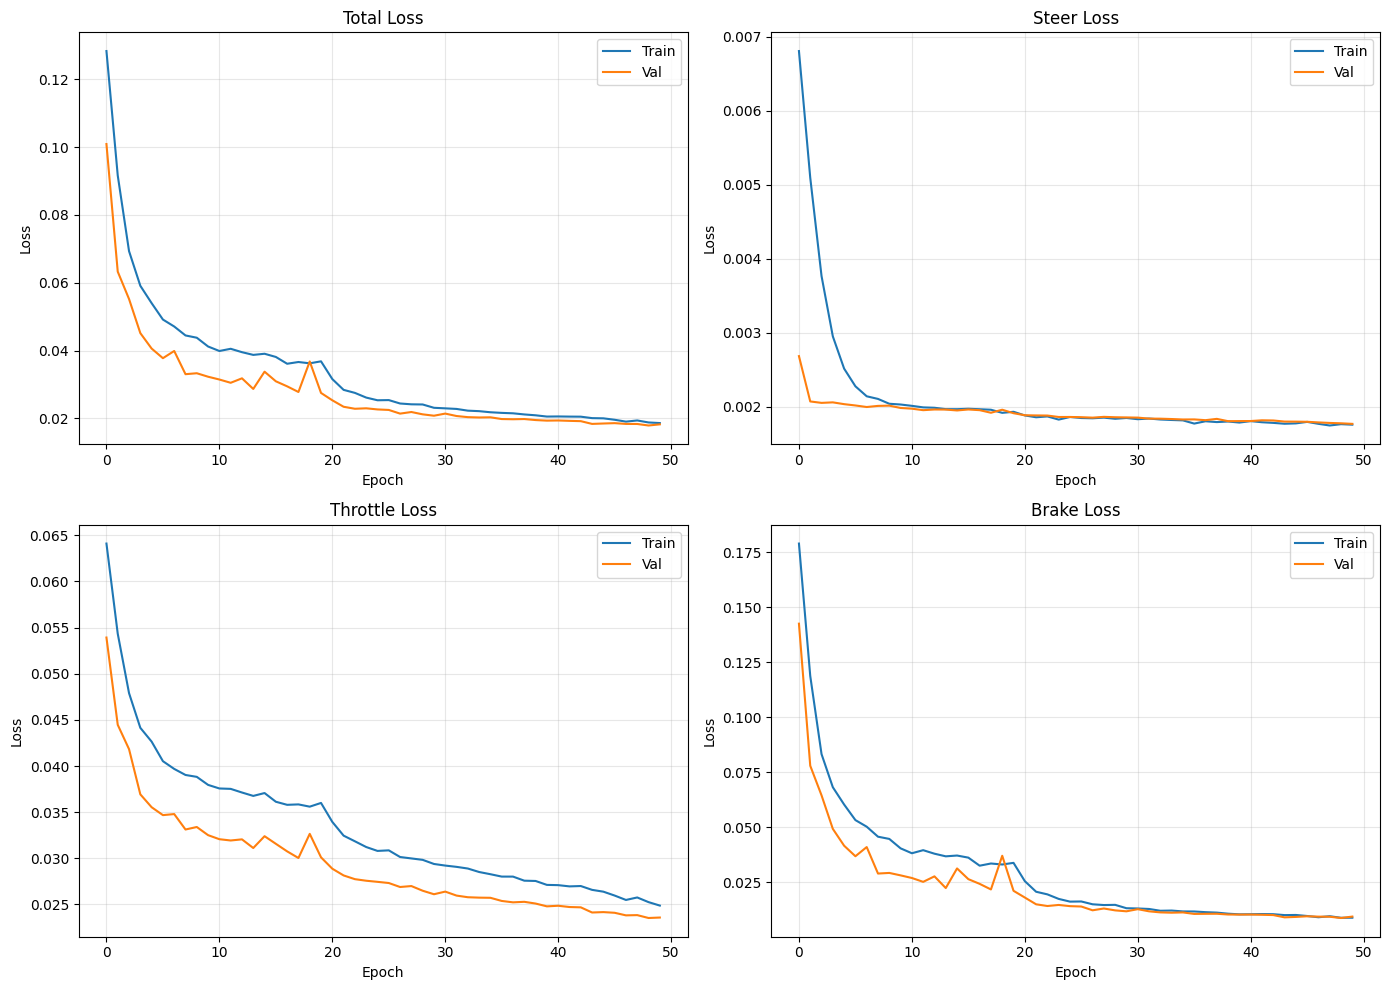

In [12]:
# Cell 12: 학습 곡선 시각화

if history['train_loss']:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Total Loss
    axes[0, 0].plot(history['train_loss'], label='Train')
    axes[0, 0].plot(history['val_loss'], label='Val')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Steer Loss
    axes[0, 1].plot(history['train_steer'], label='Train')
    axes[0, 1].plot(history['val_steer'], label='Val')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Steer Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Throttle Loss
    axes[1, 0].plot(history['train_throttle'], label='Train')
    axes[1, 0].plot(history['val_throttle'], label='Val')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Throttle Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Brake Loss
    axes[1, 1].plot(history['train_brake'], label='Train')
    axes[1, 1].plot(history['val_brake'], label='Val')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Brake Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(checkpoint_dir / 'training_curves.png', dpi=150)
    plt.show()

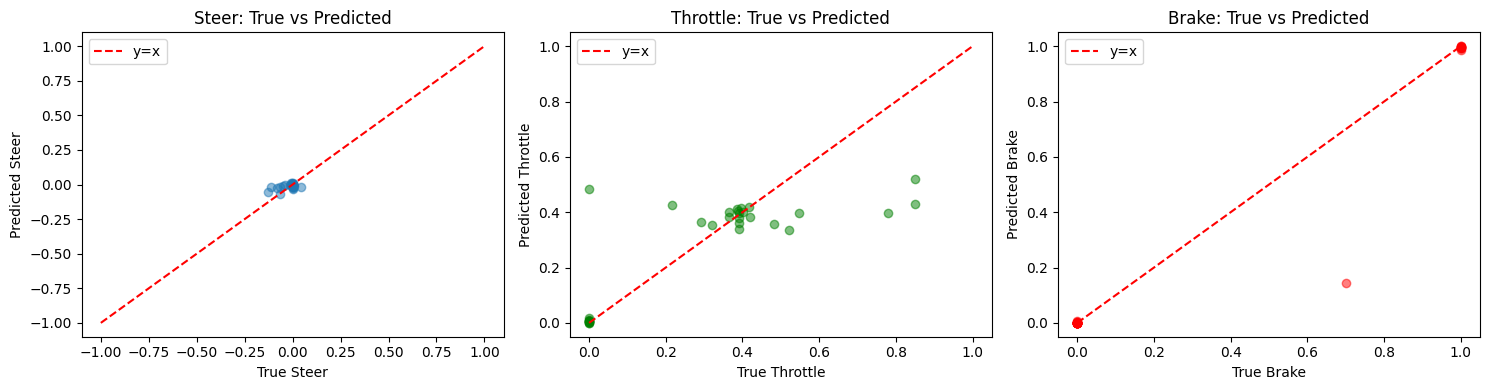

In [13]:
# Cell 13: 검증 세트 예측 시각화

if val_loader and len(history['train_loss']) > 0:
    model.eval()
    
    # 샘플 예측
    images, true_actions = next(iter(val_loader))
    images = images.to(device)
    
    with torch.no_grad():
        pred_actions = model(images).cpu().numpy()
    
    true_actions = true_actions.numpy()
    
    # 예측 vs 실제 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Steer
    axes[0].scatter(true_actions[:, 0], pred_actions[:, 0], alpha=0.5)
    axes[0].plot([-1, 1], [-1, 1], 'r--', label='y=x')
    axes[0].set_xlabel('True Steer')
    axes[0].set_ylabel('Predicted Steer')
    axes[0].set_title('Steer: True vs Predicted')
    axes[0].legend()
    
    # Throttle
    axes[1].scatter(true_actions[:, 1], pred_actions[:, 1], alpha=0.5, color='green')
    axes[1].plot([0, 1], [0, 1], 'r--', label='y=x')
    axes[1].set_xlabel('True Throttle')
    axes[1].set_ylabel('Predicted Throttle')
    axes[1].set_title('Throttle: True vs Predicted')
    axes[1].legend()
    
    # Brake
    axes[2].scatter(true_actions[:, 2], pred_actions[:, 2], alpha=0.5, color='red')
    axes[2].plot([0, 1], [0, 1], 'r--', label='y=x')
    axes[2].set_xlabel('True Brake')
    axes[2].set_ylabel('Predicted Brake')
    axes[2].set_title('Brake: True vs Predicted')
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig(checkpoint_dir / 'prediction_comparison.png', dpi=150)
    plt.show()

In [14]:
# Cell 14: 최종 모델 저장

if len(history['train_loss']) > 0:
    final_checkpoint = {
        'model_state_dict': model.state_dict(),
        'config': {
            'encoder_type': model_config['encoder']['type'],
            'feature_dim': model.feature_dim,
            'policy_hidden': model_config['policy_head']['hidden_dims']
        },
        'training_config': BC_CONFIG,
        'history': history,
        'best_val_loss': best_val_loss,
        'timestamp': datetime.now().isoformat()
    }
    
    torch.save(final_checkpoint, checkpoint_dir / 'bc_final_model.pth')
    print(f"✅ 최종 모델 저장: {checkpoint_dir / 'bc_final_model.pth'}")

print(f"\n{'='*50}")
print("행동 클로닝 학습 완료")
print(f"{'='*50}")
print(f"체크포인트 디렉토리: {checkpoint_dir}")
print(f"\n다음 단계: 06_safety_shield.ipynb")

✅ 최종 모델 저장: c:\git\automotive\checkpoints\bc\bc_final_model.pth

행동 클로닝 학습 완료
체크포인트 디렉토리: c:\git\automotive\checkpoints\bc

다음 단계: 06_safety_shield.ipynb


## 행동 클로닝 요약

### 모델 구조
- **Vision Encoder**: ResNet-50 (KITTI Self-supervised 사전학습)
- **Policy Head**: MLP [2048 → 512 → 256 → 3]
- **출력**: [steer, throttle, brake]

### 학습 전략
1. 초기: Encoder 동결, Policy Head만 학습
2. 후기: Encoder 동결 해제, 전체 fine-tuning

### 참고 논문

| 논문 | 핵심 아이디어 |
|------|---------------|
| ALVINN (Pomerleau, 1988) | 최초의 neural network 자율주행, 이미지→조향 직접 학습 |
| PilotNet (Bojarski et al., 2016) | NVIDIA의 End-to-end 자율주행, CNN 기반 |
| DAgger (Ross et al., 2011) | Distribution shift 문제 해결, 온라인 학습 |